from https://www.kaggle.com/code/jhoward/iterate-like-a-grandmaster/notebook

In [3]:
from pathlib import Path
import os

iskaggle = os.environ.get('KAGGLE_KERNEL_RUN_TYPE', '')

if iskaggle:
    !pip install -Uqq fastai

else :
    import zipfile, kaggle
    path = Path('us-patent-phrase-to-phrase-matching')
    kaggle.api.competition_download_cli(str(path))
    zipfile.ZipFile(f'{path}.zip').extractall(path)



A lot of the basic imports you'll want (np, pd, plt, etc) are provided by fastai, so let's grab them in one line:


In [4]:
from fastai.imports import *

# Import and EDA

In [5]:
if iskaggle: path = Path('../input/us-patent-phrase-to-phrase-matching')
path.ls()

(#3) [Path('../input/us-patent-phrase-to-phrase-matching/sample_submission.csv'),Path('../input/us-patent-phrase-to-phrase-matching/train.csv'),Path('../input/us-patent-phrase-to-phrase-matching/test.csv')]

Lets look at training set

In [6]:
df = pd.read_csv(path/'train.csv')
df

,id,anchor,target,context,score
0,37d61fd2272659b1,abatement,abatement of pollution,A47,0.50
1,7b9652b17b68b7a4,abatement,act of abating,A47,0.75
2,36d72442aefd8232,abatement,active catalyst,A47,0.25
3,5296b0c19e1ce60e,abatement,eliminating process,A47,0.50
4,54c1e3b9184cb5b6,abatement,forest region,A47,0.00
...,...,...,...,...,...
36468,8e1386cbefd7f245,wood article,wooden article,B44,1.00
36469,42d9e032d1cd3242,wood article,wooden box,B44,0.50
36470,208654ccb9e14fa3,wood article,wooden handle,B44,0.50
36471,756ec035e694722b,wood article,wooden material,B44,0.75


this is the test set

In [7]:
eval_df = pd.read_csv(path/'test.csv')
len(eval_df)

36

In [8]:
eval_df.head()

,id,anchor,target,context
0,4112d61851461f60,opc drum,inorganic photoconductor drum,G02
1,09e418c93a776564,adjust gas flow,altering gas flow,F23
2,36baf228038e314b,lower trunnion,lower locating,B60
3,1f37ead645e7f0c8,cap component,upper portion,D06
4,71a5b6ad068d531f,neural stimulation,artificial neural network,H04


looking at values of various fields

In [9]:
df.target.value_counts()

composition                    24
data                           22
metal                          22
motor                          22
assembly                       21
                               ..
switching switch over valve     1
switching switch off valve      1
switching over valve            1
switching off valve             1
wooden substrate                1
Name: target, Length: 29340, dtype: int64



We see that there's nearly as many unique targets as items in the training set, so they're nearly but not quite unique. Most importantly, we can see that these generally contain very few words (1-4 words in the above sample).

Let's check anchor:


In [10]:
df.anchor.value_counts()

component composite coating              152
sheet supply roller                      150
source voltage                           140
perfluoroalkyl group                     136
el display                               135
                                        ... 
plug nozzle                                2
shannon                                    2
dry coating composition1                   2
peripheral nervous system stimulation      1
conduct conducting material                1
Name: anchor, Length: 733, dtype: int64



We can see here that there's far fewer unique values (just 733) and that again they're very short (2-4 words in this sample).

Now we'll do context


In [11]:
df.context.value_counts()

H01    2186
H04    2177
G01    1812
A61    1477
F16    1091
       ... 
B03      47
F17      33
B31      24
A62      23
F26      18
Name: context, Length: 106, dtype: int64

These are just short codes. Some of them have very few examples (18 in the smallest case) The first character is the section the patent was filed under -- let's create a column for that and look at the distribution

In [12]:
df['section'] = df.context.str[0]
df.section.value_counts()

B    8019
H    6195
G    6013
C    5288
A    4094
F    4054
E    1531
D    1279
Name: section, dtype: int64



It seems likely that these sections might be useful, since they've got quite a bit more data in each.

Finally, we'll take a look at a histogram of the scores:


<AxesSubplot:>

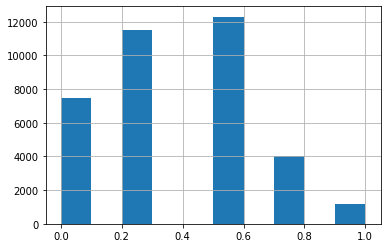

In [13]:
df.score.hist()

In [14]:
df[df.score==1]

,id,anchor,target,context,score,section
28,473137168ebf7484,abatement,abating,F24,1.0,F
158,621b048d70aa8867,absorbent properties,absorbent characteristics,D01,1.0,D
161,bc20a1c961cb073a,absorbent properties,absorption properties,D01,1.0,D
311,e955700dffd68624,acid absorption,absorption of acid,B08,1.0,B
315,3a09aba546aac675,acid absorption,acid absorption,B08,1.0,B
...,...,...,...,...,...,...
36398,913141526432f1d6,wiring trough,wiring troughs,F16,1.0,F
36435,ee0746f2a8ecef97,wood article,wood articles,B05,1.0,B
36440,ecaf479135cf0dfd,wood article,wooden article,B05,1.0,B
36464,8ceaa2b5c2d56250,wood article,wood article,B44,1.0,B




We can see from this that these are just minor rewordings of the same concept, and isn't likely to be specific to context. Any pretrained model should be pretty good at finding these already.


# training

In [15]:
from torch.utils.data import DataLoader
import warnings, transformers, logging, torch
from transformers import TrainingArguments, Trainer
from transformers import AutoModelForSequenceClassification, AutoTokenizer

In [16]:
if iskaggle:
    !pip install -q datasets
import datasets
from datasets import load_dataset, Dataset, DatasetDict



HuggingFace Transformers tends to be rather enthusiastic about spitting out lots of warnings, so let's quieten it down for our sanity:


In [17]:
warnings.simplefilter('ignore')
logging.disable(logging.WARNING)



I tried to find a model that I could train reasonably at home in under two minutes, but got reasonable accuracy from. I found that deberta-v3-small fits the bill, so let's use it:


In [18]:
model_nm = 'microsoft/deberta-v3-small'

We can now create a tokenizer for this model. Note that pretrained models assume that text is tokenized in a particular way. In order to ensure that your tokenizer matches your model, use the AutoTokenizer, passing in your model name.

In [19]:
tokz = AutoTokenizer.from_pretrained(model_nm)

Downloading:   0%|          | 0.00/52.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/578 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.35M [00:00<?, ?B/s]

We'll need to combine the context, anchor, and target together somehow. There's not much research as to the best way to do this, so we may need to iterate a bit. To start with, we'll just combine them all into a single string. The model will need to know where each section starts, so we can use the special separator token to tell it:

In [20]:
sep = tokz.sep_token
sep

'[SEP]'

In [21]:
df['inputs'] = df.context + sep + df.anchor + sep + df.target

looking at df

In [54]:
df.head()

,id,anchor,target,context,score,section,inputs,sectok
33511,ed1c4e525eb105fe,transmit alarm,display indicator,G08,0.00,G,[G] [s] G08 [s] transmit alarm [s] display indicator,[G]
18670,5386316f318f5221,locking formation,retaining element,B60,0.25,B,[B] [s] B60 [s] locking formation [s] retaining element,[B]
18049,1544ca6753fcbddd,lateral power,transducer,H01,0.25,H,[H] [s] H01 [s] lateral power [s] transducer,[H]
31660,f9d8979b94cec923,spreader body,spreader,A01,0.75,A,[A] [s] A01 [s] spreader body [s] spreader,[A]
15573,e151ca5ea5cc0f08,high gradient magnetic separators,magnetic filtration,B03,0.50,B,[B] [s] B03 [s] high gradient magnetic separators [s] magnetic filtration,[B]


Generally we'll get best performance if we convert pandas DataFrames into HuggingFace Datasets, so we'll convert them over, and also rename the score column to what Transformers expects for the dependent variable, which is label:

In [22]:
ds = Dataset.from_pandas(df).rename_column('score', 'label')
eval_ds = Dataset.from_pandas(eval_df)

In [57]:
ds[0]

{'id': '37d61fd2272659b1',
 'anchor': 'abatement',
 'target': 'abatement of pollution',
 'context': 'A47',
 'label': 0.5,
 'section': 'A',
 'inputs': 'A47[SEP]abatement[SEP]abatement of pollution'}



To tokenize the data, we'll create a function (since that's what Dataset.map will need):


In [23]:
def tok_func(x): 
    return tokz(x["inputs"])

Let's try tokenizing one input and see how it looks

In [24]:
tok_func(ds[0])

{'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}



The only bit we care about at the moment is input_ids. We can see in the tokens that it starts with a special token 1 (which represents the start of text), and then has our three fields separated by the separator token 2. We can check the indices of the special token IDs like so:


In [25]:
tokz.all_special_tokens

['[CLS]', '[SEP]', '[UNK]', '[PAD]', '[MASK]']

We can now tokenize the input. We'll use batching to speed it up, and remove the columns we no longer need:

In [26]:
inps = "anchor", "target", "context"
tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs', 'id', 'section'))

  0%|          | 0/37 [00:00<?, ?ba/s]

In [27]:
tok_ds[0]

{'label': 0.5,
 'input_ids': [1, 336, 5753, 2, 47284, 2, 47284, 265, 6435, 2],
 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

# creating a validation set



According to this post, the private test anchors do not overlap with the training set. So let's do the same thing for our validation set.

First, create a randomly shuffled list of anchors:


In [28]:
anchors = df.anchor.unique()
np.random.seed(42)
np.random.shuffle(anchors)
anchors[:5]

array(['time digital signal', 'antiatherosclerotic', 'filled interior',
       'dispersed powder', 'locking formation'], dtype=object)



Now we can pick some proportion (e.g 25%) of these anchors to go in the validation set:


In [29]:
val_prop = 0.25
val_sz = int(len(anchors)*val_prop)
val_anchors = anchors[:val_sz]



Now we can get a list of which rows match val_anchors, and get their indices:


In [30]:
is_val = np.isin(df.anchor, val_anchors)
idxs = np.arange(len(df))
val_idxs = idxs[is_val]
trn_idxs = idxs[~is_val]
len(val_idxs), len(trn_idxs)

(9116, 27357)

Our training and validation Datasets can now be selected, and put into a DatasetDict ready for training:

In [31]:
dds = DatasetDict({"train": tok_ds.select(trn_idxs), 
                   "test": tok_ds.select(val_idxs)})



BTW, a lot of people do more complex stuff for creating their validation set, but with a dataset this large there's not much point. As you can see, the mean scores in the two groups are very similar despite just doing a random shuffle:


In [32]:
df.iloc[trn_idxs].score.mean(), df.iloc[val_idxs].score.mean()

(0.3623021530138539, 0.3613426941641071)

# initial model



Let's now train our model! We'll need to specify a metric, which is the correlation coefficient provided by numpy (we need to return a dictionary since that's how Transformers knows what label to use):


In [33]:
def corr(eval_pred): return {'pearson': np.corrcoef(*eval_pred)[0][1]}



We pick a learning rate and batch size that fits our GPU, and pick a reasonable weight decay and small number of epochs:


In [34]:
lr, bs = 8e-5, 128
wd, epochs = 0.01, 4



Three epochs might not sound like much, but you'll see once we train that most of the progress can be made in that time, so this is good for experimentation.

Transformers uses the TrainingArguments class to set up arguments. We'll use a cosine scheduler with warmup, since at fast.ai we've found that's pretty reliable. We'll use fp16 since it's much faster on modern GPUs, and saves some memory. We evaluate using double-sized batches, since no gradients are stored so we can do twice as many rows at a time.


In [35]:
def get_trainer(dds):
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)

In [36]:
args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,num_train_epochs=epochs, weight_decay=wd, report_to='none')

In [37]:
model = AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)
trainer = Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'], tokenizer=tokz, compute_metrics=corr)

Downloading:   0%|          | 0.00/273M [00:00<?, ?B/s]

In [38]:
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.028006,0.788895
2,No log,0.025104,0.810376
3,0.037000,0.024000,0.817113
4,0.037000,0.024755,0.815944


TrainOutput(global_step=856, training_loss=0.027186344160097783, metrics={'train_runtime': 247.7179, 'train_samples_per_second': 441.744, 'train_steps_per_second': 3.456, 'total_flos': 469191313065600.0, 'train_loss': 0.027186344160097783, 'epoch': 4.0})

# improving the model



We now want to start iterating to improve this. To do that, we need to know whether the model gives stable results. I tried training it 3 times from scratch, and got a range of outcomes from 0.808-0.810. This is stable enough to make a start - if we're not finding improvements that are visible within this range, then they're not very significant! Later on, if and when we feel confident that we've got the basics right, we can use cross validation and more epochs of training.

Iteration speed is critical, so we need to quickly be able to try different data processing and trainer parameters. So let's create a function to quickly apply tokenization and create our DatasetDict:


In [39]:


def get_dds(df):
    ds = Dataset.from_pandas(df).rename_column('score', 'label')
    tok_ds = ds.map(tok_func, batched=True, remove_columns=inps+('inputs','id','section'))
    return DatasetDict({"train":tok_ds.select(trn_idxs), "test": tok_ds.select(val_idxs)})





...and also a function to create a Trainer:


In [40]:
def get_model(): return AutoModelForSequenceClassification.from_pretrained(model_nm, num_labels=1)

def get_trainer(dds, model=None):
    if model is None: model = get_model()
    args = TrainingArguments('outputs', learning_rate=lr, warmup_ratio=0.1, lr_scheduler_type='cosine', fp16=True,
        evaluation_strategy="epoch", per_device_train_batch_size=bs, per_device_eval_batch_size=bs*2,
        num_train_epochs=epochs, weight_decay=wd, report_to='none')
    return Trainer(model, args, train_dataset=dds['train'], eval_dataset=dds['test'],
                   tokenizer=tokz, compute_metrics=corr)



Let's now try out some ideas...

Perhaps using the special separator character isn't a good idea, and we should use something we create instead. Let's see if that makes things better. First we'll change the separator and create the DatasetDict:


In [41]:
sep = " [s] "
df['inputs'] = df.context + sep + df.anchor + sep + df.target
dds = get_dds(df)

  0%|          | 0/37 [00:00<?, ?ba/s]



...and create and train a model.


In [42]:
get_trainer(dds).train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024942,0.799117
2,No log,0.025590,0.814783
3,0.031300,0.023194,0.820567
4,0.031300,0.024171,0.819860


TrainOutput(global_step=856, training_loss=0.023601023950309396, metrics={'train_runtime': 259.9313, 'train_samples_per_second': 420.988, 'train_steps_per_second': 3.293, 'total_flos': 582440534448480.0, 'train_loss': 0.023601023950309396, 'epoch': 4.0})



That's looking quite a bit better, so we'll keep that change.

Often changing to lowercase is helpful. Let's see if that helps too:


In [43]:
df['inputs'] = df.inputs.str.lower()
dds = get_dds(df)
get_trainer(dds).train()

  0%|          | 0/37 [00:00<?, ?ba/s]

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024730,0.799405
2,No log,0.025684,0.813678
3,0.031500,0.023043,0.820755
4,0.031500,0.024291,0.819741


TrainOutput(global_step=856, training_loss=0.023727591349699786, metrics={'train_runtime': 260.2759, 'train_samples_per_second': 420.431, 'train_steps_per_second': 3.289, 'total_flos': 582440534448480.0, 'train_loss': 0.023727591349699786, 'epoch': 4.0})



That one is less clear. We'll keep that change too since most times I run it, it's a little better.


# creating our own special tokens

In [44]:
df['sectok'] = '[' + df.section + ']'
sectoks = list(df.sectok.unique())
tokz.add_special_tokens({'additional_special_tokens': sectoks})

8

concatenating the section token to the start of our inputs

In [45]:
df['inputs'] = df.sectok + sep + df.context + sep + df.anchor.str.lower() + sep + df.target
dds = get_dds(df)

  0%|          | 0/37 [00:00<?, ?ba/s]



Since we've added more tokens, we need to resize the embedding matrix in the model:


In [46]:


model = get_model()
model.resize_token_embeddings(len(tokz))



Embedding(128009, 768)

Now we are ready to train

In [47]:
trainer = get_trainer(dds, model=model)
trainer.train()

Epoch,Training Loss,Validation Loss,Pearson
1,No log,0.024826,0.797162
2,No log,0.025376,0.817938
3,0.031800,0.023239,0.822923
4,0.031800,0.023447,0.824512


TrainOutput(global_step=856, training_loss=0.023839535557221028, metrics={'train_runtime': 278.5211, 'train_samples_per_second': 392.889, 'train_steps_per_second': 3.073, 'total_flos': 695689755831360.0, 'train_loss': 0.023839535557221028, 'epoch': 4.0})

Jeremy presents with many more ideas



It looks like we've made another bit of an improvement!

There's plenty more things you could try. Here's some thoughts:

    Try a model pretrained on legal vocabulary. E.g. how about BERT for patents?
    You'd likely get better results by using a sentence similarity model. Did you know that there's a patent similarity model you could try?
    You could also fine-tune any HuggingFace model using the full patent database (which is provided in BigQuery), before applying it to this dataset
    Replace the patent context field with the description of that context provided by the patent office
    ...and try out your own ideas too!

Before submitting a model, retrain it on the full dataset, rather than just the 75% training subset we've used here. Create a function like the ones above to make that easy for you!"


# cross validation

In [48]:
n_folds =4



Once you've gotten the low hanging fruit, you might want to use cross-validation to see the impact of minor changes. This time we'll use StratifiedGroupKFold, partly just to show a different approach to before, and partly because it will give us slightly better balanced datasets.


In [49]:
from sklearn.model_selection import StratifiedGroupKFold
cv = StratifiedGroupKFold(n_splits=n_folds)



Here's how to split the data frame into n_folds groups, with non-overlapping anchors and matched scores, after randomly shuffling the rows:


In [50]:


df = df.sample(frac=1, random_state=42)
scores = (df.score*100).astype(int)
folds = list(cv.split(idxs, scores, df.anchor))
folds



[(array([    0,     1,     2, ..., 36469, 36471, 36472]),
  array([    8,    13,    14, ..., 36453, 36464, 36470])),
 (array([    0,     1,     5, ..., 36470, 36471, 36472]),
  array([    2,     3,     4, ..., 36459, 36461, 36462])),
 (array([    1,     2,     3, ..., 36467, 36470, 36472]),
  array([    0,     7,    11, ..., 36468, 36469, 36471])),
 (array([    0,     2,     3, ..., 36469, 36470, 36471]),
  array([    1,     5,     9, ..., 36465, 36467, 36472]))]



We can now create a little function to split into training and validation sets based on a fold:


In [51]:


def get_fold(folds, fold_num):
    trn,val = folds[fold_num]
    return DatasetDict({"train":tok_ds.select(trn), "test": tok_ds.select(val)})



Lets try it out

In [52]:
dds = get_fold(folds, 0)
dds

DatasetDict({
    train: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 27346
    })
    test: Dataset({
        features: ['label', 'input_ids', 'token_type_ids', 'attention_mask'],
        num_rows: 9127
    })
})



We can now pass this into get_trainer as we did before. If we have, say, 4 folds, then doing that for each fold will give us 4 models, and 4 sets of predictions and metrics. You could ensemble the 4 models to get a stronger model, and can also average the 4 metrics to get a more accurate assessment of your model. Here's how to get the final epoch metrics from a trainer:


In [53]:
metrics = [o['eval_pearson'] for o in trainer.state.log_history if 'eval_pearson' in o]
metrics[-1]

0.8245123117960352